In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline



In [3]:
df_train=pd.read_csv('../input/titanic/train.csv')
df_test=pd.read_csv('../input/titanic/test.csv')
df_all=pd.concat([df_train,df_test],axis=0)



In [4]:
df_all.reset_index(drop=True,inplace=True)
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 1.Now we will start basic EDA

In [5]:
print('Number of Training Examples =',df_train.shape[0])
print('Number of Testing Examples =',df_test.shape[0])
print('Columns of training data: ',df_train.columns,'Number of columns:',len(df_train.columns))
print('Columns of testing data: ',df_test.columns,'Number of columns:',len(df_test.columns))
print('The extra column in training data is',set(df_train.columns)-set(df_test.columns))

Number of Training Examples = 891
Number of Testing Examples = 418
Columns of training data:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') Number of columns: 12
Columns of testing data:  Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') Number of columns: 11
The extra column in training data is {'Survived'}


The target variable here is **Survived**

In [6]:
print(df_all.Pclass.value_counts())
print(df_all.Embarked.value_counts())

3    709
1    323
2    277
Name: Pclass, dtype: int64
S    914
C    270
Q    123
Name: Embarked, dtype: int64


#### 1.1 **Overview of features**
* PassengerId has no effect on target var.
* Survived is the target variable(0 or 1):
    * 1=Survived
    * 0=Deceased
* Pclass( Passenger Class) is a categorical variable(ordinal) having 3 unique values (1,2,3):
    * 1=Upper Class
    * 2=Middle Class
    * 3=Lower Class
* Name, Sex and Age are self-explanatory
* SibSp is the total number of the passengers' siblings and spouse
* Parch is the total number of the passengers' parents and children
* Ticket is the ticket number of the passenger
* Fare is the passenger fare
* Cabin is the cabin number of the passenger
* Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
     * S is Southampton
     * C is Cherbourg
     * Q is Queenstown

One can see the types of features


features_obj=[]
features_num=[]
for features in df_all.columns:


In [7]:

features_obj=[]
features_num=[]
for features in df_all.columns:
    if df_all[features].dtype=='object':
        features_obj.append(features)
    else:
        features_num.append(features)


**Here we have segregated the types of features**

In [8]:
print('String Features :', features_obj)
print('Numerical Features :',features_num )

String Features : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Numerical Features : ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [9]:
df_all.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.028814,-0.077221,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.178740,0.160238,0.221539,1.000000


In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Do some univariate analysis before filling out/Tableau

**1.2 Missing Values**
It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. 
The count of missing values in Age, Embarked and Fare are smaller compared to total sample, but roughly 80% of the Cabin is missing. Missing values in **Age, Embarked and Fare** can be filled with *descriptive statistical measures* but that wouldn't work for Cabin.

Studying correlations will help us a lot.


In [11]:
for feature in df_all.columns:
    print(feature,' percent missing value:',100*df_all[feature].isnull().sum()/df_all.shape[0])

PassengerId  percent missing value: 0.0
Survived  percent missing value: 31.932773109243698
Pclass  percent missing value: 0.0
Name  percent missing value: 0.0
Sex  percent missing value: 0.0
Age  percent missing value: 20.091673032849503
SibSp  percent missing value: 0.0
Parch  percent missing value: 0.0
Ticket  percent missing value: 0.0
Fare  percent missing value: 0.07639419404125286
Cabin  percent missing value: 77.46371275783041
Embarked  percent missing value: 0.15278838808250572


Text(0.5, 1.0, 'Pearson Correlation Heatmap')

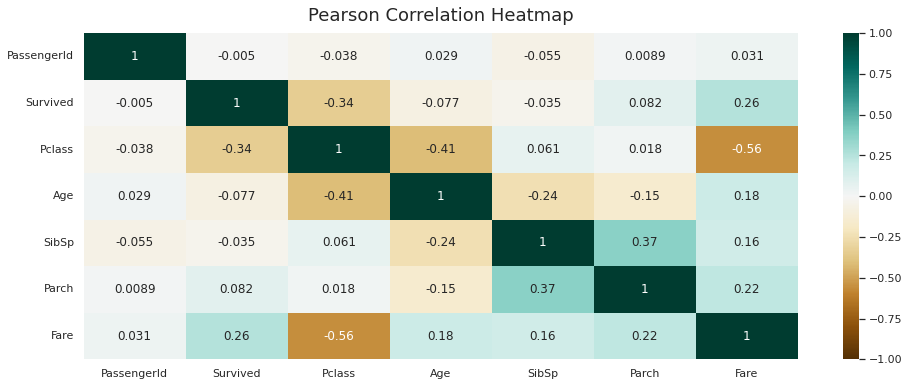

In [12]:
plt.figure(figsize=(16,6))
heatmap=sns.heatmap(df_all.corr(),vmin=-1,vmax=1,annot=True,cmap='BrBG')
heatmap.set_title('Pearson Correlation Heatmap',fontdict={'fontsize':18},pad=12)


**1.2.1 Age**
Missing values in Age are filled with

<AxesSubplot:>

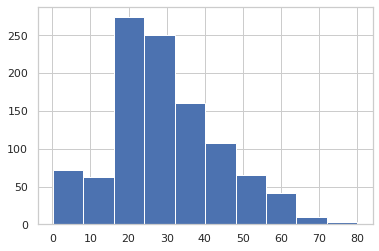

In [13]:
df_all.Age.hist(bins=10)

You can clearly see that the younger age bracket is mostly present

In [14]:
df_all[df_all.Age.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [15]:
df_all.corr()[['Age']].sort_values(by='Age',ascending=False)

,Age
Age,1.000000
Fare,0.178740
PassengerId,0.028814
Survived,-0.077221
Parch,-0.150917
SibSp,-0.243699
Pclass,-0.408106


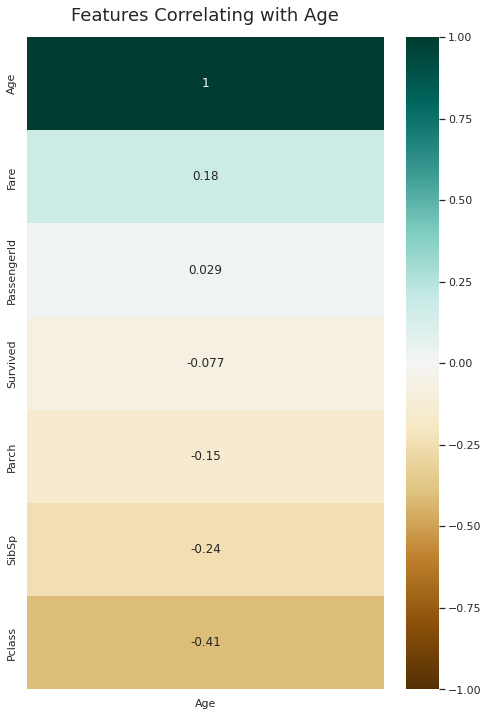

In [16]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_all.corr()[['Age']].sort_values(by='Age',ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Age', fontdict={'fontsize':18}, pad=16);

From here we can clearly assume that Pclass and Age are highly related.Therefore we will impute the missing value by median of the corresponding Pclass.